In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = "/Users/malhark/Documents/CS129/chest_xray/train/"
# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=32)

# val_dir = "/Users/malhark/Documents/CS129/chest_xray/train/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# test_dir = "/Users/malhark/Documents/CS129/chest_xray/test/"
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(2*val_batches // 3)
val_ds = val_ds.skip(2*val_batches // 3)

# test_ds = tf.keras.utils.image_dataset_from_directory(
#   train_dir,
#   seed=123,
#   image_size=IMG_SIZE,
#   batch_size=BATCH_SIZE)


Found 15064 files belonging to 3 classes.
Using 10545 files for training.
Found 15064 files belonging to 3 classes.
Using 4519 files for validation.


In [ ]:
train_ds.class_names

['BACTERIAL', 'NORMAL', 'VIRAL']

In [ ]:
num_bac, num_vir, num_norm, num_tot = 0, 0, 0, 0
for ds in [train_ds, val_ds, test_ds]:
    for i_batch, l_batch in ds:
        num_bac += np.sum(l_batch == 0)
        num_vir += np.sum(l_batch == 2)
        num_norm += np.sum(l_batch == 1)
        num_tot += len(l_batch)

print(num_norm, num_bac, num_vir, num_tot)
print(np.array([num_norm, num_bac, num_vir])/num_tot)

4853 5771 4440 15064
[0.32215879 0.38309878 0.29474243]


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))

Number of validation batches: 48
Number of test batches: 94
Number of train batches: 330


In [ ]:
def get_label(data, label):
    return label

# Map the function over the dataset to extract labels
label_dataset = test_ds.map(get_label)

# def label_to_binary(label):
#     # Assuming you have two classes, you can customize this based on your actual classes
#     # For example, if you have classes 'cat' and 'dog', you can return 1 for 'cat' and 0 for 'dog'
#     return label

# # Map the function over the label dataset to convert labels to binary representation
# binary_label_dataset = label_dataset.map(label_to_binary)

# # Convert the dataset to a NumPy array
# train_labels = np.array([], dtype=int)
# for l in binary_label_dataset:
#     train_labels = np.concatenate([train_labels, l.numpy()], axis=0)

# print(np.sum(train_labels) / len(train_labels))

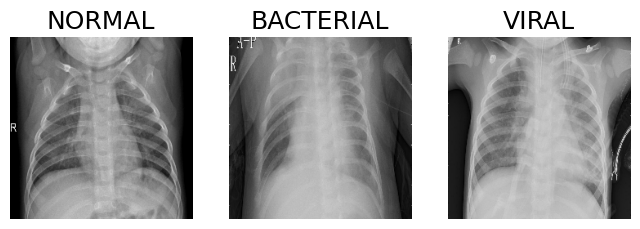

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]], fontsize=18)
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  i = image_batch
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# use this to rescale image values from [0, 255] to [-1, 1]

In [ ]:
## Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(units=3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

48/48 [==============================] - 17s 194ms/step - loss: 1.2903 - sparse_categorical_accuracy: 0.3422


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
330/330 [==============================] - 84s 249ms/step - loss: 0.9083 - sparse_categorical_accuracy: 0.5856 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.7366
Epoch 2/10
330/330 [==============================] - 84s 251ms/step - loss: 0.6480 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.5649 - val_sparse_categorical_accuracy: 0.7790
Epoch 3/10
330/330 [==============================] - 86s 257ms/step - loss: 0.5659 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.5209 - val_sparse_categorical_accuracy: 0.7876
Epoch 4/10
330/330 [==============================] - 87s 263ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.7815 - val_loss: 0.4876 - val_sparse_categorical_accuracy: 0.8054
Epoch 5/10
330/330 [==============================] - 91s 274ms/step - loss: 0.5057 - sparse_categorical_accuracy: 0.7911 - val_loss: 0.4788 - val_sparse_categorical_accuracy: 0.8021
Epoch 6/10
330/330 [==============================] - 86s 258ms/step - loss: 0.4890 -

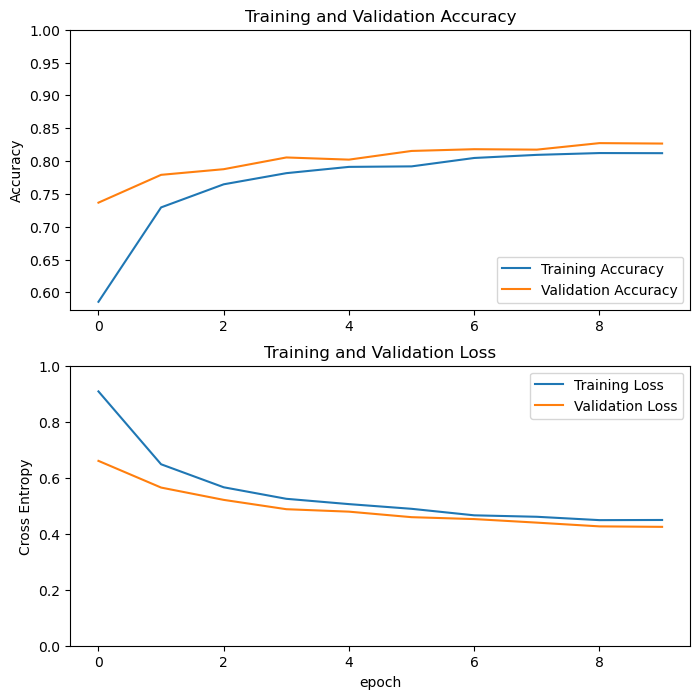

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

94/94 [==============================] - 21s 213ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.8311
Test accuracy : 0.8311170339584351


In [ ]:
print(len(base_model.layers))

fine_tune_at = 140
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
330/330 [==============================] - 102s 303ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8229 - val_loss: 0.3821 - val_sparse_categorical_accuracy: 0.8385
Epoch 11/20
330/330 [==============================] - 94s 285ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.8424 - val_loss: 0.3831 - val_sparse_categorical_accuracy: 0.8339
Epoch 12/20
330/330 [==============================] - 94s 284ms/step - loss: 0.3556 - sparse_categorical_accuracy: 0.8521 - val_loss: 0.3530 - val_sparse_categorical_accuracy: 0.8524
Epoch 13/20
330/330 [==============================] - 94s 283ms/step - loss: 0.3294 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.3415 - val_sparse_categorical_accuracy: 0.8663
Epoch 14/20
330/330 [==============================] - 96s 289ms/step - loss: 0.3103 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.8736
Epoch 15/20
330/330 [==============================] - 95s 286ms/step - loss: 0

In [ ]:
acc = history.history['sparse_categorical_accuracy']# + history_fine.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']# + history_fine.history['val_sparse_categorical_accuracy']

loss = history.history["loss"] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

In [ ]:
loss

0.421194851398468

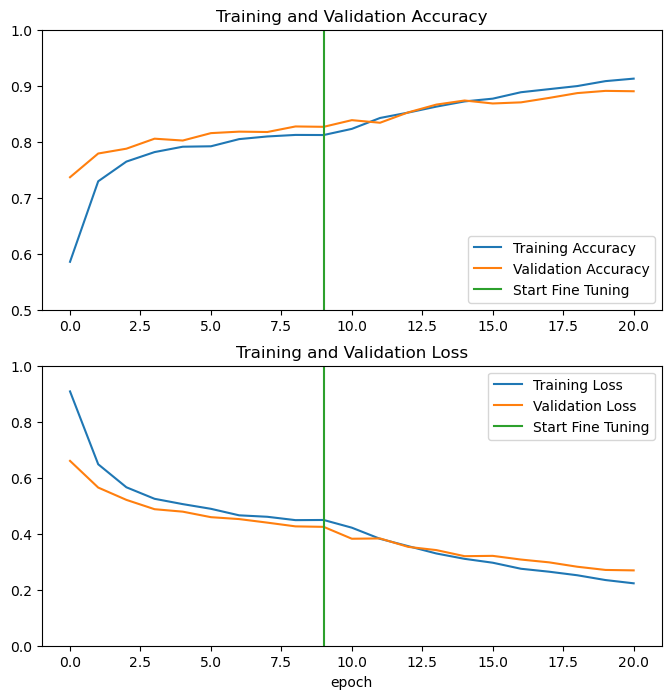

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim((0.5, 1)), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

94/94 [==============================] - 56s 581ms/step - loss: 0.2765 - sparse_categorical_accuracy: 0.8850
Test accuracy : 0.884973406791687


Predictions:
 [1 2 1 1 0 0 1 2 2 1 0 2 1 2 0 1 1 1 1 2 0 1 1 1 0 1 1 0 1 1 1 0]
Labels:
 [1 2 1 1 0 0 1 2 2 1 0 0 1 2 0 1 1 1 1 2 0 1 1 1 0 1 1 0 1 1 1 0]


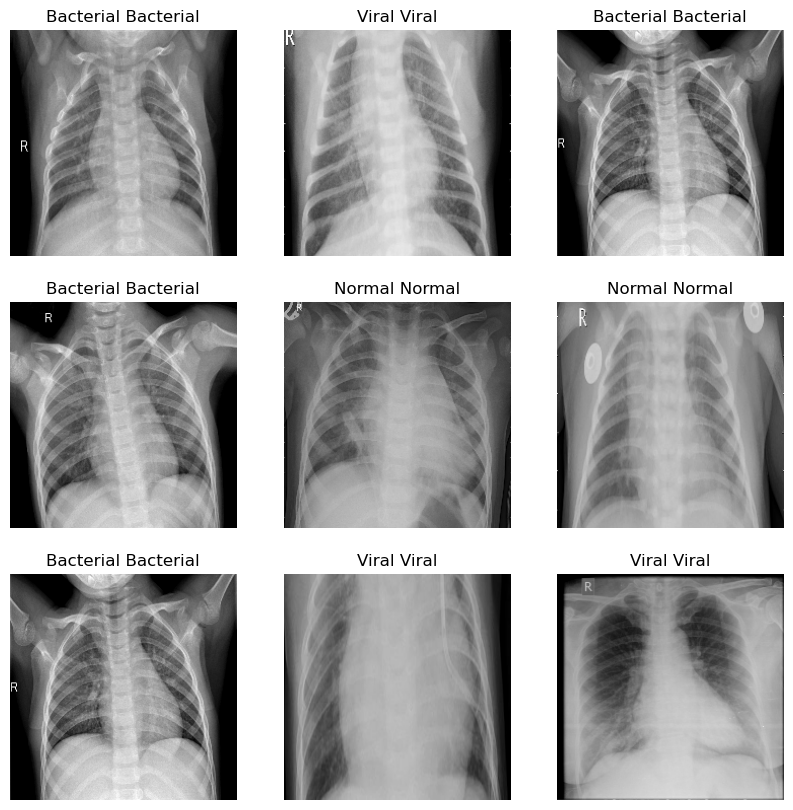

In [ ]:
class_names = ["Normal", "Bacterial", "Viral", "Uncertain"]
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
logits = np.exp(predictions).transpose() / np.sum(np.exp(predictions), axis=1)
predictions = np.argmax(np.exp(predictions), axis=1)  # index with largest logit
uncertain = np.max(logits, axis=0) <= 0.5
predictions[uncertain] = 3


print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]] + " " + class_names[label_batch[i]])
  plt.axis("off")

In [ ]:
all_labels = np.array([], dtype=int)
# all_predictions = np.array([], dtype=int)
all_predictions = []
for im, la in test_ds.as_numpy_iterator():
    # print(i.shape, l.shape)
    predictions = model.predict_on_batch(im)
    # predictions = np.argmax(tf.nn.softmax(predictions), axis=1)
    # logits = np.exp(predictions).transpose() / np.sum(np.exp(predictions), axis=1)
    predictions = np.argmax(np.exp(predictions), axis=1)  # index with largest logit
    # uncertain = np.max(logits, axis=0) <= 0.5
    # predictions[uncertain] = 3

    all_labels = np.concatenate([all_labels, la])
    # all_predictions = np.concatenate([all_predictions, predictions])
    all_predictions.append(predictions)

all_predictions = np.array(all_predictions).flatten()

In [ ]:
assert len(all_labels) == len(all_predictions)
test_size = len(all_labels)

acc = np.sum(all_labels == all_predictions) / test_size
# fp = np.sum(np.all([all_predictions, all_labels==False], axis=0))
# tp = np.sum(np.all([all_predictions, all_labels], axis=0))
# fn = np.sum(np.all([all_predictions==False, all_labels], axis=0))
# tn = np.sum(np.all([all_predictions==False, all_labels==False], axis=0))

# fpr = fp/(fp + tn)
# fnr = fn/(fn + tp)
# tpr = tp/(tp + fn)
# tnr = tn / (tn + fp)

print(acc)  #TODO: get this accuracy to match...
# print(fp, tp, fn, tn)
# print(fpr, fnr, tpr, tnr)

0.8826462765957447


In [ ]:
0.8843085106382979 * test_size

2660.0

In [ ]:
0.884973406791687 * test_size

2662.0000076293945

In [ ]:
model.save('xray_031324_finetuning.keras')

In [ ]:
fine_tune_epochs2 = 10
total_epochs2 =  total_epochs + fine_tune_epochs

history_fine2 = model.fit(train_ds,
                         epochs=total_epochs2,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
330/330 [==============================] - 246s 743ms/step - loss: 0.2124 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.2590 - val_sparse_categorical_accuracy: 0.8994
Epoch 21/30
330/330 [==============================] - 235s 708ms/step - loss: 0.2009 - sparse_categorical_accuracy: 0.9246 - val_loss: 0.2584 - val_sparse_categorical_accuracy: 0.8934
Epoch 22/30
330/330 [==============================] - 224s 677ms/step - loss: 0.1891 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.2671 - val_sparse_categorical_accuracy: 0.8895
Epoch 23/30
330/330 [==============================] - 223s 673ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.2370 - val_sparse_categorical_accuracy: 0.9073
Epoch 24/30
330/330 [==============================] - 224s 675ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.8908
Epoch 25/30
330/330 [==============================] - 224s 674ms/step - lo

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

94/94 [==============================] - 48s 499ms/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9139
Test accuracy : 0.9138962626457214


In [ ]:
acc = history.history['sparse_categorical_accuracy'] + history_fine2.history['sparse_categorical_accuracy']
# val_acc += history_fine2.history['val_sparse_categorical_accuracy']

loss = history.history["loss"] + history_fine.history['loss'] + history_fine2.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss'] + history_fine2.history['val_loss']

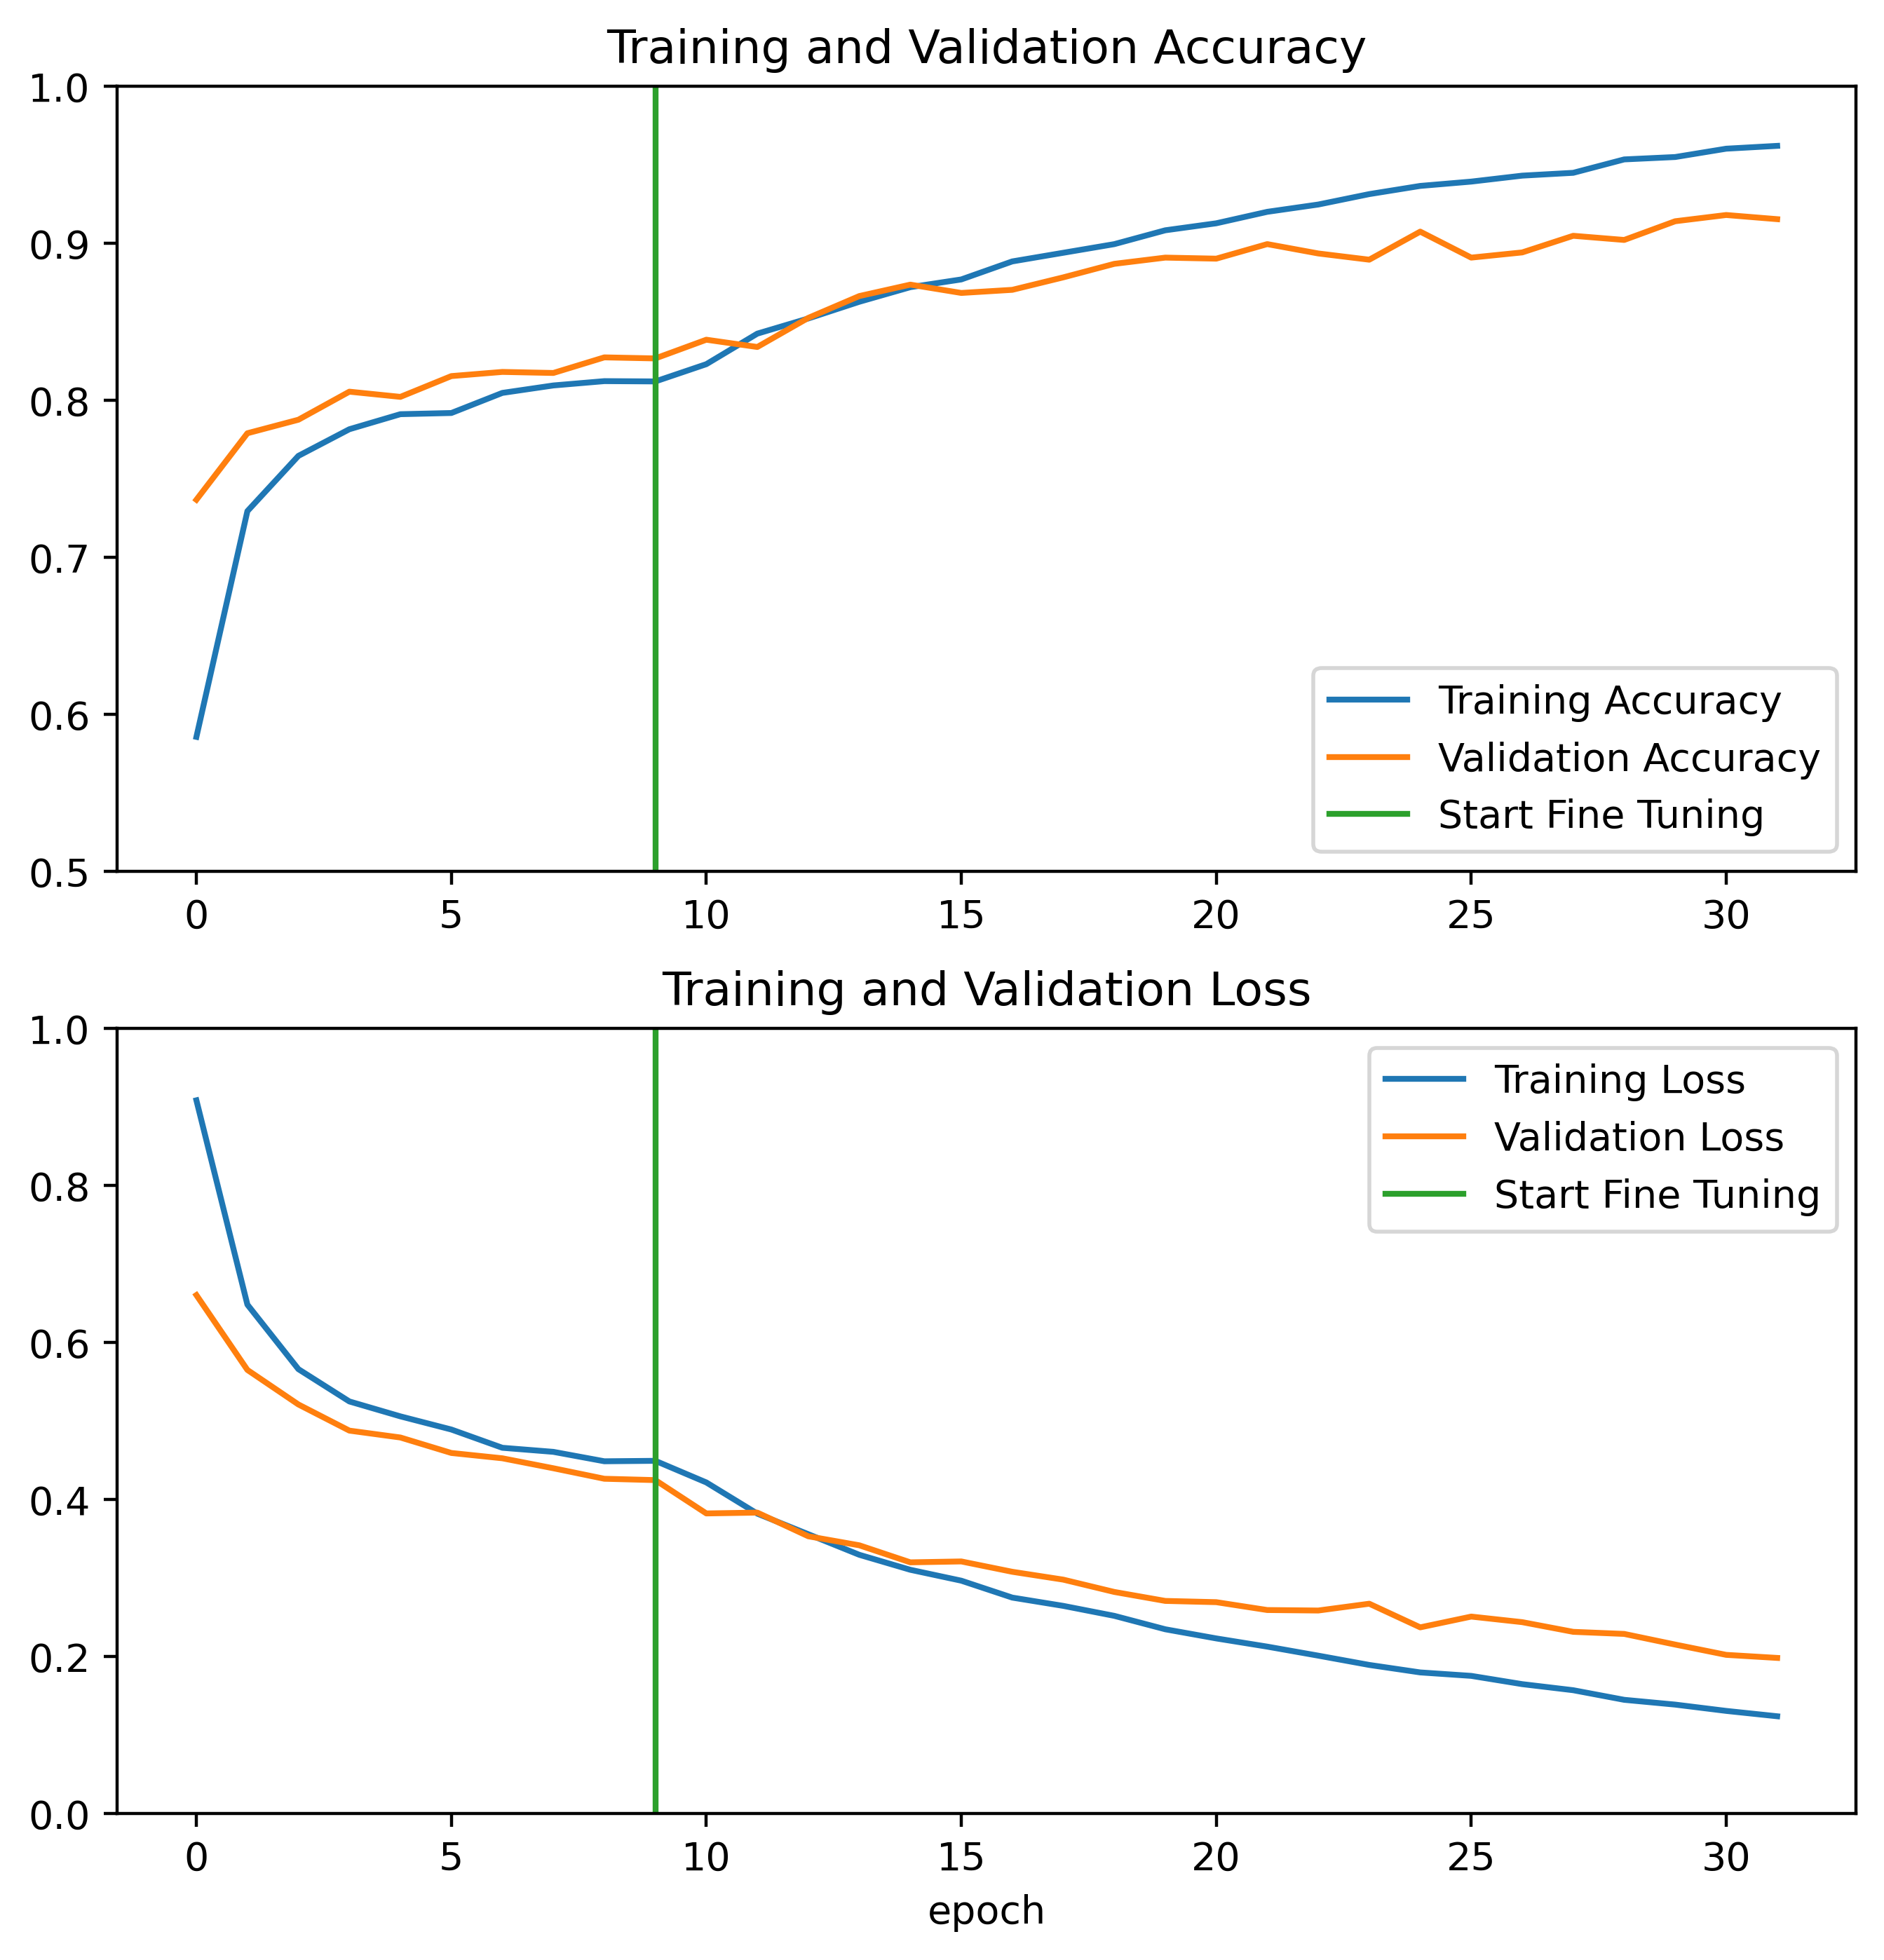

In [ ]:
plt.figure(figsize=(8, 8), dpi=400)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim((0.5, 1)), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
all_labels = np.array([], dtype=int)
# all_predictions = np.array([], dtype=int)
all_predictions = []
for im, la in test_ds.as_numpy_iterator():
    # print(i.shape, l.shape)
    predictions = model.predict_on_batch(im)
    # predictions = np.argmax(tf.nn.softmax(predictions), axis=1)
    # logits = np.exp(predictions).transpose() / np.sum(np.exp(predictions), axis=1)
    predictions = np.argmax(np.exp(predictions), axis=1)  # index with largest logit
    # uncertain = np.max(logits, axis=0) <= 0.5
    # predictions[uncertain] = 3

    all_labels = np.concatenate([all_labels, la])
    # all_predictions = np.concatenate([all_predictions, predictions])
    all_predictions.append(predictions)

all_predictions = np.array(all_predictions).flatten()

In [ ]:
con_mat = tf.math.confusion_matrix(all_labels, all_predictions, num_classes=3)
print(np.sum(all_labels==all_predictions)/len(all_labels))
print(con_mat)

0.914561170212766
tf.Tensor(
[[985   9 146]
 [  2 987   3]
 [ 84  13 779]], shape=(3, 3), dtype=int32)


In [ ]:
con_rate_mat = con_mat.numpy() / np.sum(con_mat, axis=1)
print(con_rate_mat)

[[0.86403509 0.00907258 0.16666667]
 [0.00175439 0.99495968 0.00342466]
 [0.07368421 0.01310484 0.88926941]]
